In [1]:
from __future__ import print_function
%matplotlib inline
import matplotlib.pylab as plt
import sys, os
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['font.size'] = 18

# Gutenberg N-Grams

In this notebook, we will quantitatively explore the text of the [Gutenberg E-Books Project](https://www.gutenberg.org/), a free repository of e-books that are in the public domain. All of the English and German books have been downloaded for this tutorial and a small python package has been made available that allows you to easily parse the text and the associated metadata. 

But before we get to using the data, we need to take care of a few setup issues. 

## Setting up Python and Spark

Setting up the spark environment can be a bit of a trial and error procedure. Often you'll need to configure settings (in particular dealing with memory) to fit your cluster and your particular application. Below, we will specify a few of the most important ones -- but you can see the full list in the [Spark Configuration guide](http://spark.apache.org/docs/latest/configuration.html) and if you are using YARN there are critical options also listed under the [YARN deployment guide](http://spark.apache.org/docs/latest/running-on-yarn.html).

## Python environment setup

First, we need to make sure that the `pyspark` libraries are accessible in this notebook. To do this, we can add them to the library search path: 

In [2]:
import sys
try: 
    spark_home = os.environ['SPARK_HOME']
except KeyError: 
    raise KeyError("You must specify the SPARK_HOME environment variable -- is the Spark module loaded?")

python_lib_path = glob.glob('%s/python/lib/py4j*zip'%spark_home)[0]
sys.path.insert(0,spark_home+'/python')
sys.path.insert(0,python_lib_path)

## Runtime settings

### Driver memory

The memory allocated to the Spark driver is often an insignificant parameter, but it your driver ends up having to handle a lot of data (i.e. in large reduces or if it collects subsamples of the dataset) then this could be important. With the YARN scheduler, it's not very obvious how to specify this value nicely, but using the environment variable seems to work. Note that this has to be done *before* importing the `pyspark` package. Once this is set and the `pyspark` package imported, you may need to restart the python kernel if you want to make a change. You can see how much memory has been allocated to the driver either in the Spark Web UI or in the messages printed to the console at initialization. 

In [3]:
os.environ['SPARK_DRIVER_MEMORY'] = '8g'

In [4]:
import pyspark
from pyspark import SparkConf, SparkContext

### Initializing `SparkConf` 
When starting the Spark runtime through the notebook or inside a script (i.e. when not calling one of the spark scripts like `spark_submit`), you can create a `SparkConf` object that allows you to set up the runtime. This is quite convenient and much more clean and readable than specifying the options on the commandline.

In [5]:
# put the number of executors and cores into variables so we can refer to it later
num_execs = 20
exec_cores = 4

In [6]:
# initializing the SparkConf
conf = SparkConf()

### Executor options

The full list of options is very long, but the basic ones you'll *always* want to at least think about are ones pertaining to the basic configuration of the executors: number of executors, memory per executor, and number of cores per executor. 

A few notes about the memory configuration: the `spark.executor.memory` should not be set to the total memory of the node. Some memory is needed for the OS (including HDFS and other services), and still more is required for the Spark overhead. So in our case here, we have 16 Gb of memory per node but can only use around 12 Gb of this for the executors. Since we need to leave room for 10% YARN overhead, we specify 9 Gb here to be safe. If your executors start dying off for strange reasons, try reducing the memory here. 

In [7]:
conf.set('spark.executor.memory', '9g')
conf.set('spark.executor.instances', str(num_execs))
conf.set('spark.executor.cores', str(exec_cores))

### Memory configuration

Two other key memory options exist, specifying the amount of executor memory reserved for *cached* data and for *shuffle* data. Depending on what your application is doing, you may need more of one or the other. For example, if you are running a lot of iterative operations on a large dataset, you probably want a good amount of memory for RDD caching. On the other hand, if you are doing lots of expensive shuffles that occur when sorting of grouping by key, you may want more shuffle memory. Note that if either one starts to run low, your application won't crash it will simply spill to disk. This usually isn't as bad as it sounds especially if the OS file cache kicks in. 

You can check on the cache memory and shuffle memory in two ways while your application is running. In the Spark UI, you can see the cached RDDs under the `Storage` tab - if they start spilling to disk, this is where you will see it. Similarly, if you are running a large shuffle job, you can click on the stage details in the Spark UI and see the shuffle memory and disk statistics. We will check on both of these later on in this application. 

Here we will set these two options explicitly for completeness, but actually keep the values at their defaults (60%  of the heap for caching, 20% for shuffles). 

In [8]:
conf.set('spark.storage.memoryFraction', 0.6)
conf.set('spark.shuffle.memoryFraction', 0.2)

Finally, just to make sure, specify the driver memory also here:

In [9]:
conf.set('spark.driver.memory', '8g')

### `PATH` and `PYTHONPATH`

In some cases we need to tell the executors explicitly where the non-standard python libraries are located (this includes the spark libraries and seems to be new in Spark 1.4.0 -- a bug?). For this, we set the environment variable `PYTHONPATH`. Any other environment variable can be specified in this way, should it be needed.

In [10]:
conf.set('spark.executorEnv.PYTHONPATH', 
         '/cluster/apps/spark/spark-1.4.0-bin-hadoop2.6/python/lib/py4j-0.8.2.1-src.zip:/cluster/apps/spark/spark-1.4.0-bin-hadoop2.6/python/:/cluster/home03/sdid/roskarr/spark_workshop/gutenberg')

Since we are using a custom python (miniconda), we also set the `PATH` explicitly: 

In [11]:
conf.set('spark.executorEnv.PATH', os.environ['PATH'])

### Starting the `SparkContext`
This is our entry point to the Spark runtime - it is used to push data into spark or load RDDs from disk etc. 

In [12]:
sc = SparkContext(master = 'yarn-client', conf = conf)

If this works successfully, you can check the [YARN application scheduler](http://a3000.hpc-net.ethz.ch:8088/cluster) and you should see your app listed there. Clicking on the "Application Master" link will bring up the familiar Spark Web UI. 

## Make a key-value RDD of book metadata and text

Getting data into spark from a collection of local files is a very common task. A useful pattern to keep in mind is the following: 

1. make a list of filenames and distribute it among the workers
3. "map" each filename to the data you want to get out
4. now you are left with the RDD of raw data distributed among the workers!

In our case of the Gutenberg Project e-book data, we have a directory of `html` files which hold the actual book text, and another directory of associated metadata files (the RDF files). To make your life easier for the purpose of this tutorial, we have made a small python module called `gutenberg_cleanup` that has some handy functions for pulling out the relevant text and metadata out of the raw dataset. 

The [`gutenberg_cleanup`](gutenberg_cleanup.py) module contains three functions that can help with this: `get_gid`, `get_metadata` and `get_text`.

They pretty much do the obvious: 

`get_gid` takes an html path and pulls out the book ID (`gid`)

`get_metadata` takes a `gid` and returns a metadata object with various useful fields that will be used to create a unique key for each book

`get_text` takes a path to an html file and returns the raw text extracted from HTML, cleaned of tags and punctuation and converted to lower case. 

### Initializing the raw dataset using `sc.parallelize`

In [13]:
import glob

# get a list of all html files in the data directory
flist = glob.glob('/cluster/home03/sdid/roskarr/work/gutenberg/html/*html')
print('number of books: ', len(flist))

number of books:  15081


When you use `sc.parallelize` to distribute a dataset across the cluster, you can choose the number of partitions across which to distribute the dataset. The higher the number of partitions, the higher the "parallelism". When Spark subsequently executes maps and reduces on this dataset, it does so by dispatching tasks to different executors, which then request the cores under their control to do the actual work. By increasing the number of partitions, you increase the number of tasks - more tasks gives the Spark scheduler more flexibility in distributing the work across the cluster and therefore maximally leveraging the compute resources at its disposal. In some cases, where a single partition might require a lot of memory it can cause `Out of memory` errors - in such cases, simply reducing the amount of data per task by increasing the parallelism can help. 

Note that the latency of scheduling is pretty low - as long as tasks take a few hundred milliseconds the scheduler should have no trouble dispatching them. On the other hand, there is a bit of overhead associated with partitioning the data so you don't want an unreasonably high number of partitions. You can see the [Spark guide](http://spark.apache.org/docs/latest/tuning.html#level-of-parallelism) for a bit more detail. 

Below, we will choose to use 5 times as many partitions as we have cores in the cluster. 

In [14]:
files_rdd = sc.parallelize(flist, num_execs*exec_cores*5)

In [15]:
files_rdd.take(5)

['/cluster/home03/sdid/roskarr/work/gutenberg/html/1000.html',
 '/cluster/home03/sdid/roskarr/work/gutenberg/html/1001.html',
 '/cluster/home03/sdid/roskarr/work/gutenberg/html/1002.html',
 '/cluster/home03/sdid/roskarr/work/gutenberg/html/1003.html',
 '/cluster/home03/sdid/roskarr/work/gutenberg/html/1004.html']

### Transforming the list of filenames into a `key,value` pair RDD of metadata and text

Use the `get_gid`, `get_text` and `get_metadata` functions to construct a key,value pair RDD, where `key` is the dictionary returned by `get_metadata`. For the `value` of each `key`,`value` pair use the raw text returned by `get_text`. 

In [16]:
import gutenberg_cleanup
from gutenberg_cleanup import get_metadata, get_text, get_gid

Here are the doc strings for the three functions you'll need to ingest the data: 

In [17]:
help(get_gid)
help(get_metadata)
help(get_text)

Help on function get_gid in module gutenberg_cleanup:

get_gid(html_path)
    Return the Gutenberg book ID (`gid`) give the path to the raw html file.
    
    Input:
        `html_path`: path to the html Gutenberg book file
    
    Output:
        `gid`: the ID of the Gutenberg book

Help on function get_metadata in module gutenberg_cleanup:

get_metadata(gid, rdf_path='/cluster/home03/sdid/roskarr/work/gutenberg/rdf-files/')
    Extract the metadata from the Gutenberg book represented by the gid.
    
    Inputs:
        `gid`: the Gutenberg project book ID
    
    Optional Keywords:
         `rdf_path`: path to the Gutenberg project RDF projects
    
    Outputs:
        dictionary containing the book metadata

Help on function get_text in module gutenberg_cleanup:

get_text(html_path)
    Clean HTML tags, escape characters, special unicode, punctuation, and empty spaces from the raw html
    
    Inputs:
        `html_path`: path to the raw html Gutenberg project book file
    
 

Use the `map` method of `files_rdd` to map the filenames to `(metadata, text)` tuples: 

In [18]:
text_rdd = (files_rdd.map(lambda filename: (get_metadata(get_gid(filename)), get_text(filename))))

So that we don't have to constantly re-load the data off disk, lets cache this RDD: 

In [19]:
%%time
text_rdd.cache()
text_rdd.count()

CPU times: user 127 ms, sys: 29 ms, total: 156 ms
Wall time: 50.7 s


Since we called `count()`, it means that the entire RDD was generated/calculated. This combination of `cache` and `count` is a common way to check how much memory your dataset needs - once `count` completes you can check the memory taken up by the RDD by going to the "Storage" tag of the Spark UI. 

Because the data is cached, next time you try to use `text_rdd` it will be much much quicker. For example, 

In [20]:
%%time
text_rdd.count()

CPU times: user 75 ms, sys: 24 ms, total: 99 ms
Wall time: 1.86 s


15081

As an aside, we could call the native python `map` in exactly the same way (and run it on the local machine only), though this would take much longer to complete, i.e. 

    text = map(lambda f: (get_metadata(get_gid(f)), get_text(f)), flist)

Lets have a look at what this RDD looks like now: 

In [21]:
text_rdd.first()

({'birth_year': None,
  'death_year': None,
  'downloads': u'243',
  'first_name': None,
  'gid': 1000,
  'lang': u'en',
  'last_name': None,
  'title': '- No Title -'},
 'pageno position absolute right font medium sansserif textindent pagenoafter color gray content attrtitle lineno position absolute left font medium sansserif textindent linenoafter color gray content attrtitle tocpageref float right pre fontfamily monospace fontsize em whitespace prewrap in italian with no accentsbit text please see my notes about various versions beneath this header copyright laws are changing all over the world be sure to check the copyright laws for your country before posting these files please take a look at the important information in this header we encourage you to keep this file on your own disk keeping an electronic path open for the next readers do not remove this information on contacting project gutenberg to get etexts and further information is included below we need your donations this 

### Saving the metadata as a broadcast variable

As we manipulate the dataset, we will want ready access to the metadata, but we don't want to have to read it off the disk every time. We can extract it from the RDD and save it in a dictionary for later use: 

In [22]:
# set up the list of fields
metadata_fields = text_rdd.first()[0].keys() # this takes the metadata of the first element and extracts the keys
meta_dict = dict()
for meta in text_rdd.keys().collect() :
    meta_dict[meta['gid']] = {key: meta[key] for key in metadata_fields}

This is now a look-up table that allows us to quickly access all the metadata indexed by `gid`. For example:

In [23]:
meta_dict[101]

{'birth_year': u'1954',
 'death_year': None,
 'downloads': u'352',
 'first_name': u'Bruce',
 'gid': 101,
 'lang': u'en',
 'last_name': u'Sterling',
 'title': u'The Hacker Crackdown: Law and Disorder on the Electronic Frontier'}

To get, for example, the author birth year for book with `gid = 101`:

In [24]:
meta_dict[101]['birth_year']

u'1954'

We'll need this lookup table often in the analysis. Since it will be used in many `map` transformations, we would have to send it across the wire every time we used it. Alternatively, we could read the metadata off the disk every time, but this is even worse for many reasons (for one, there are many thousands of RDF files). 

Instead, Spark offers us a [broadcast variable](http://spark.apache.org/docs/latest/programming-guide.html#broadcast-variables) mechanism. This allows us to distribute a non-trivial piece of data to all nodes and keep it there. When the code running on the nodes needs a value from the broadcast variable, it is simply grabbed from memory. Since the variable is stored in the JVM on the executor, if the executor runs many cores, those cores can share the data therefore even further reducing unnecessary network traffic. 

In [25]:
# call it meta_b for 'broadcast'
meta_b = sc.broadcast(meta_dict)

The underlying data object stored in `meta_b` can be accessed simply by

    > meta_b.value
    
We'll make use of this soon. If you check the console output, you will see an INFO message that the broadcast has been created, i.e. 

```
15/06/24 17:18:44 INFO storage.MemoryStore: Block broadcast_6_piece0 stored as bytes in memory (estimated size 910.7 KB, free 4.1 GB)
15/06/24 17:18:44 INFO storage.BlockManagerInfo: Added broadcast_6_piece0 in memory on 10.201.20.22:47821 (size: 910.7 KB, free: 4.1 GB)
15/06/24 17:18:44 INFO spark.SparkContext: Created broadcast 6 from broadcast at PythonRDD.scala:403
```

## Save the raw dataset to HDFS (or local storage)

As a final bit of preparation before continuing with analysis, we save the raw data in a way that makes it faster to access later. We don't want to have to read the data off local disk every time we need to repeat some part of the analysis. Instead, it's much more advantageous to use the Hadoop Distributed File System (HDFS) to store the data once we've read it in and put it in a `key,value` format. 

In [ ]:
text_rdd.saveAsPickleFile('hdfs:///user/roskarr/gutenberg/raw_text_rdd')

Now, whenever we need it, we can read the data off the HDFS instead: 

In [27]:
loaded_text_rdd = sc.pickleFile('hdfs:///user/roskarr/gutenberg/raw_text_rdd')

In [28]:
%time loaded_text_rdd.count()

CPU times: user 101 ms, sys: 23 ms, total: 124 ms
Wall time: 10.8 s


15081

Compare this read time to nearly two minutes it took to read it off the local filesystem initially. If you look at the details for this stage in the Spark UI you can understand why this is: in the column named "locality level", you see that for many tasks it says `NODE LOCAL` while for others it might say `RACK LOCAL`. These mean that either the data chunk was physically present on the disk of the node that was reading it in (`NODE LOCAL`) or it was on one of the nodes on the same switch (`RACK LOCAL`). Of course the additional advantage is not having to deal with the filesystem overhead of 10k+ small files.  

## Cleaning the data with filtering

Now we're ready to do some quality checks on the data. Let's check out the first couple of metadata entries: 

In [29]:
text_rdd.keys().take(5)

[{'birth_year': None,
  'death_year': None,
  'downloads': u'243',
  'first_name': None,
  'gid': 1000,
  'lang': u'en',
  'last_name': None,
  'title': '- No Title -'},
 {'birth_year': u'1265',
  'death_year': u'1321',
  'downloads': u'931',
  'first_name': None,
  'gid': 1001,
  'lang': u'en',
  'last_name': u'Dante Alighieri',
  'title': u"Divine Comedy, Longfellow's Translation, Hell"},
 {'birth_year': u'1807',
  'death_year': u'1882',
  'downloads': u'25',
  'first_name': None,
  'gid': 1002,
  'lang': u'en',
  'last_name': u'Dante Alighieri',
  'title': u"Divine Comedy, Longfellow's Translation, Purgatory"},
 {'birth_year': u'1265',
  'death_year': u'1321',
  'downloads': u'24',
  'first_name': None,
  'gid': 1003,
  'lang': u'en',
  'last_name': u'Dante Alighieri',
  'title': u"Divine Comedy, Longfellow's Translation, Paradise"},
 {'birth_year': u'1807',
  'death_year': u'1882',
  'downloads': u'434',
  'first_name': None,
  'gid': 1004,
  'lang': u'en',
  'last_name': u'Dante A

If you look at just the first few entries it becomes clear that we're going to have to do some quality control here. For example, we probably don't want books with "None" as either of the author names, and likewise we have to have the birth date in order to be able to create a time series out of the data in the end. 

Construct an RDD, as above, except that you filter out all the elements that have `None` for `title`, `first_name`, `last_name`, or `birth_year`. In addition, filter out the data with "BC" in either birth or death year. 

The `filter_func` has already been defined for you, but you need to apply it to `text_rdd`

In [30]:
def filter_func(meta) : 
    no_none = all([meta[name] is not None for name in ['title', 'first_name', 'last_name', 'birth_year']])
    if not no_none : 
        return False
    else : 
        no_birth_bc = 'BC' not in meta['birth_year']
        no_death_bc = True if meta['death_year'] is None else 'BC' not in meta['death_year']
        return no_birth_bc + no_death_bc

In [31]:
filtered_rdd = text_rdd.filter(lambda (meta, text): filter_func(meta))

In [32]:
filtered_rdd.keys().take(5)

[{'birth_year': u'1954',
  'death_year': None,
  'downloads': u'352',
  'first_name': u'Bruce',
  'gid': 101,
  'lang': u'en',
  'last_name': u'Sterling',
  'title': u'The Hacker Crackdown: Law and Disorder on the Electronic Frontier'},
 {'birth_year': u'1866',
  'death_year': u'1946',
  'downloads': u'430',
  'first_name': u'H. G. (Herbert George)',
  'gid': 1013,
  'lang': u'en',
  'last_name': u'Wells',
  'title': u'The First Men in the Moon'},
 {'birth_year': u'1874',
  'death_year': u'1940',
  'downloads': u'60',
  'first_name': u'B. M.',
  'gid': 1014,
  'lang': u'en',
  'last_name': u'Bower',
  'title': u'The Lure of the Dim Trails'},
 {'birth_year': u'1823',
  'death_year': u'1893',
  'downloads': u'265',
  'first_name': u'Francis',
  'gid': 1015,
  'lang': u'en',
  'last_name': u'Parkman',
  'title': u'The Oregon Trail: Sketches of Prairie and Rocky-Mountain Life'},
 {'birth_year': u'1632',
  'death_year': u'1677',
  'downloads': u'207',
  'first_name': u'Benedictus de',
  'gi

How many do we have left? 

In [33]:
print('number of books after filtering: ', filtered_rdd.count())

number of books after filtering:  11872


A final bit of cleanup: 

some of the books end up in multiple files, but they should all have the same `gid`. 

To check for this we will use one of the most basic and common MapReduce patterns -- the key count: 

* map the data into `key`,`value` pairs where `key` is the quantity we want to count and `value` is just 1. 
* invoke a reduction *by key*, where the reduction operator is a simple addition

Finally, we will sort the result and print out the first few elements to check whether we have to worry about documents spanning multiple files or not. 

The RDD operations that are needed are [`reduceByKey`](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.reduceByKey) and [sortBy](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.sortBy).

For the `keyFunc` of the call to `sortBy`, use a `lambda` function that extracts the counts obtained from the `reduceByKey`. 

In [34]:
from operator import add

In [ ]:
map_filtered = filtered_rdd.map(<FILL>)

reduced_map = filter_map.reduceByKey(add)

sorted_reduced = reduced_map.sortBy(<FILL>)

sorted_reduced.take(20)

Note that there are several transformations here that lead to the final result, `sorted_reduced`. A common syntax is to group them all together, by enclosing them in `( )` and chaining them: 

In [35]:
# FILL IN
(filtered_rdd.map(lambda (meta, text): (meta['gid'], 1))
             .reduceByKey(add)
             .sortBy(lambda (key,count): count, False)
             .take(20))

[(6478, 43),
 (3772, 40),
 (8700, 35),
 (3332, 33),
 (12233, 29),
 (3425, 23),
 (2440, 16),
 (6475, 15),
 (12145, 9),
 (12383, 7),
 (15000, 6),
 (10625, 5),
 (4022, 5),
 (12030, 5),
 (16927, 4),
 (21053, 4),
 (10800, 4),
 (14052, 3),
 (14860, 3),
 (18436, 2)]

Looks like we have a few that are made up of multiple sections. To combine them, we will use `reduceByKey` which will result in having an RDD of `gid`'s as keys and the combined text of each `gid`. The reduction function in `reduceByKey` can be a simple in-line function that just adds two elements together (but can't be the `add` function because that expects the arguments to be numbers). 

In [69]:
# FILL IN
cleaned_rdd = (filtered_rdd.map(lambda (meta, text): (meta['gid'], text))
                           .reduceByKey(lambda a,b: a+b))

As a simple sanity check, lets look at `gid`=6478, which according to the cell above has 43 sections in the original dataset: 

In [37]:
len(filtered_rdd.map(lambda (meta, text): (meta['gid'],1))
                .lookup(6478))

43

In [38]:
len(cleaned_rdd.lookup(6478))

1

To avoid having to do all these pre-processing steps again at a later point, lets also save the `cleaned_rdd`:

In [41]:
cleaned_rdd.saveAsPickleFile('/user/roskarr/gutenberg/cleaned_rdd')

This is now saved in the directory we specified, one file per partition:

In [42]:
!hadoop fs -ls /user/roskarr/gutenberg/cleaned_rdd

Picked up _JAVA_OPTIONS: -XX:ParallelGCThreads=1
15/06/23 17:39:28 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Found 401 items
-rw-r--r--   3 roskarr supergroup          0 2015-06-23 17:39 /user/roskarr/gutenberg/cleaned_rdd/_SUCCESS
-rw-r--r--   3 roskarr supergroup   50650862 2015-06-23 17:39 /user/roskarr/gutenberg/cleaned_rdd/part-00000
-rw-r--r--   3 roskarr supergroup   14597171 2015-06-23 17:39 /user/roskarr/gutenberg/cleaned_rdd/part-00001
-rw-r--r--   3 roskarr supergroup    9321127 2015-06-23 17:39 /user/roskarr/gutenberg/cleaned_rdd/part-00002
-rw-r--r--   3 roskarr supergroup   12393074 2015-06-23 17:39 /user/roskarr/gutenberg/cleaned_rdd/part-00003
-rw-r--r--   3 roskarr supergroup   12062283 2015-06-23 17:39 /user/roskarr/gutenberg/cleaned_rdd/part-00004
-rw-r--r--   3 roskarr supergroup   12041333 2015-06-23 17:39 /user/roskarr/gutenberg/cleaned_rdd/part-00005
-rw-r--r--   3 roskarr sup

## Processing the data

We're finished with the basic pre-processing. Our `cleaned_rdd` contains `gid`'s as keys and text as values. If we want some other piece of metadata, we can just access it via the lookup table, for example `meta_b.value[gid][meta_name]`. 

### Histogram of book publication years
Now we're ready to start asking some questions of the data. To begin with, lets do a simple histogram of the year distribution of the books. Since we don't have original publication dates, we just use the simple formula: 

$year = max\left((year_{birth} + year_{death})/2, year_{birth} + offset\right)$, 

where $offset$ is a number drawn from a gaussian centered on 40 with $\sigma = 5$ years. This means that we assume most people write their books around 40. ;)

The function `publication_year` is provided for you and you should use it to *transform* the `year_rdd` into an RDD of publication years. 

In [39]:
import numpy as np
def publication_year(meta) : 
    birth_year = int(meta['birth_year'])
    if meta['death_year'] is None : 
        year = birth_year + np.random.normal(40,5)
    else :
        death_year = int(meta['death_year'])
        year = max((birth_year + death_year) / 2.0, birth_year+np.random.normal(40,5))

    return min(int(year),2015)

In [76]:
# FILL IN 
year_rdd = (cleaned_rdd.map(lambda (gid, text): publication_year(get_metadata(gid)))
                       .cache())
year_rdd.count()

11598

The histogram function actually already exists in the Spark API (but it didn't use to!). However, for fun we will write our own. Calculating the histogram can be split up into two parts. First, we need to figure out which bin each value corresponds to: 

1. take bins and a value as input
2. calculate the bin that the value maps to and return (`bin`, 1) pair

Second, we need to do a simple `reduceByKey` where we just add up all the values belonging to each bin. 

In [41]:
# define a helper function to determine which bin a value falls into
from bisect import bisect_right
def get_bin(bin_edges, value) : 
    """Returns which bin, specified by `bin_edges` the `value` falls into."""
    return bisect_right(bin_edges, value) - 1

In [51]:
def histogram(rdd, nbins = 100, min_val=None, max_val=None) :
    # if either min_val or max_val are missing, get them from the data
    if min_val is None : 
        min_val = rdd.min() # FILL IN
    if max_val is None : 
        max_val = rdd.max() # FILL IN
        
    bin_edges = np.linspace(min_val,max_val,nbins+1)
    
    binned_rdd = rdd.map(lambda x: (get_bin(bin_edges, x),1)) # FILL IN 
    
    summed_bins = binned_rdd.reduceByKey(lambda a,b:a+b).collect() # FILL IN 
    
    # This is a sparse result -- turn into a dense vector for plotting: 
    res_full = np.zeros(nbins)
    overflow = 0
    for item in summed_bins : 
        if item[0] > len(res_full)-1 or item[0] < 0: 
            continue # ignore
        else: res_full[item[0]] = item[1]
            
    return .5*(bin_edges[:-1]+bin_edges[1:]), res_full

In [74]:
# FILL IN 
%time bins, vals = histogram(year_rdd, min_val=1500, max_val=2015)

CPU times: user 171 ms, sys: 41 ms, total: 212 ms
Wall time: 1.23 s


This kind of operation is a good candidate for computing a partial result on each partition followed by a reduce step. This can dramatically reduce the network traffic. Instead of mapping each value to a bin and doing a potentially expensive shuffle during the `reduceByKey` operation, we can compute a histogram locally on each partition and then simply add them up at the end. 

Here is where our knowledge of generators comes in handy!

In [77]:
def bin_partition(iterator, nbins,  min_val, max_val) : 
    from bisect import bisect_right
    
    bin_edges = np.linspace(min_val,max_val,nbins+1)
    
    bin_vals = np.zeros(len(bin_edges)-1)
    
    for item in iterator : 
        try : 
            bin_vals[bisect_right(bin_edges, item)-1] += 1
        except IndexError : 
            pass
        
    yield bin_vals

def histogram_partition(rdd, nbins = 100, min_val=None, max_val=None) :
    # if either min_val or max_val are missing, get them from the data
    if min_val is None : 
        min_val = rdd.min() # FILL IN
    if max_val is None : 
        max_val = rdd.max() # FILL IN
        
    bin_edges = np.linspace(min_val,max_val,nbins+1)
    
    result = (rdd.mapPartitions(lambda iterator: bin_partition(iterator, nbins, min_val, max_val))
                 .reduce(lambda a,b: a+b))
    
    return .5*(bin_edges[:-1]+bin_edges[1:]), result

In [79]:
%time bins, vals = histogram_partition(year_rdd, min_val=1500, max_val=2015)

CPU times: user 106 ms, sys: 24 ms, total: 130 ms
Wall time: 611 ms


The difference here doesn't look dramatic because the total amount of data is rather small, but have a look at the Spark Web UI and you will see that the second implementation didn't do any shuffle writing. With a bigger data set, this difference would potentially matter a lot. 

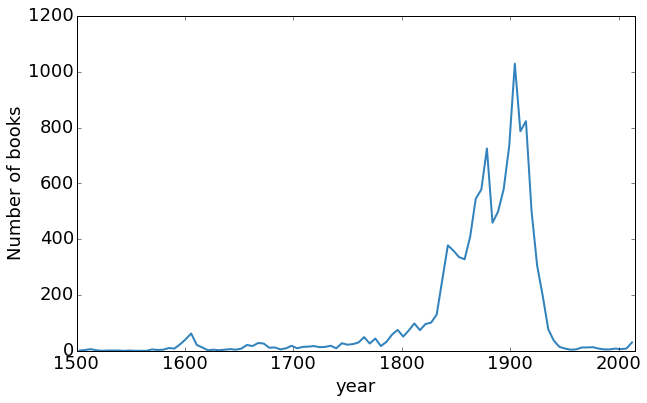

In [80]:
plt.plot(bins, vals, color = '#3182bd', lw=2)
plt.xlim(1500,2015)
plt.xlabel('year')
plt.ylabel('Number of books')

### Inspecting the metadata some more

Lets do a couple more checks and practice using the Spark API. 

How many unique authors are there in the dataset? 

1. make `author_rdd` that is composed of a string `"last_name, first_name"`
2. keep only the unique author strings (*hint*: look at the Spark API to find an appropriate method)
3. count the number of elements remaining

In [49]:
# FILL IN 
author_rdd = cleaned_rdd.map(lambda (gid, text): 
                             "%s %s"%(meta_b.value[gid]['last_name'], meta_b.value[gid]['first_name']))

In [50]:
# FILL IN
n_authors = (author_rdd.distinct()
                       .count())
print "Number of distinct authors: %s " % n_authors

Number of distinct authors: 3831 


Most-represented authors in the corpus: 

1. use the `author_rdd` from above
2. use the pattern `(key, 1)` to set up an RDD that can be passed to `reduceByKey`
3. run `reduceByKey`, yielding an RDD composed of `(author, count)` tuples
4. sort by descending order of number of books per author

In [51]:
(author_rdd.map(lambda author: (author, 1))
           .reduceByKey(lambda a,b: a+b)
           .takeOrdered(10, lambda (a,c): -1*c))

[(u'Lytton Baron Lytton', 212),
 (u'Ebers Georg', 163),
 (u'Shakespeare William', 145),
 (u'Twain Mark', 139),
 (u'Parker Gilbert', 131),
 (u'Meredith George', 107),
 (u'Motley John Lothrop', 102),
 (u'Jacobs W. W. (William Wymark)', 102),
 (u'Pepys Samuel', 87),
 (u'Hawthorne Nathaniel', 80)]

Finally, lets do the same thing per language, just to get an idea of how much data there is: 

In [52]:
# FILL IN 
lang_rdd = cleaned_rdd.map(lambda (gid, text): meta_b.value[gid]['lang'])

In [53]:
# FILL IN: reduce the `lang_rdd` to yield number of books in each language
lang_rdd.map(lambda l: (l,1)).reduceByKey(lambda a,b: a+b).collect()

[(u'en', 10706), (u'de', 892)]

## How many words were used in these 500 years? 
### Construct a corpus-wide vocabulary

We could have done the above metadata gymnastics without ever invoking a distributed processing framework of course by simply extracting the years from the metadata. The text body of each data element is where the bulk of the data volume lies. 

To construct a corpus wide vocabulary, we have to deconstruct each document into a list of words and then extract the unique words from the entire data set. If our dataset fit into memory of a single machine, this is a simple set operation. But what if it doesn't? 

We'll assume this is the case and instead of converting each `gid,text` pair into a `gid,list_of_words` pair, we will simply construct one RDD of words. Here we aren't necessarily interested in preserving the provenance of words, but just finding the unique words in the whole corpus. 

1. map the entire RDD of text into an RDD of single words
2. use the `distinct` method of the resulting RDD to transform it into an RDD with only unique words

*Hint:* In python, splitting a string into a set of words separated by spaces is easy: 

In [54]:
line = 'splitting a string is super simple'
line.split()

['splitting', 'a', 'string', 'is', 'super', 'simple']

Make an RDD `distinct_rdd` which holds the *unique English* words:

In [55]:
# FILL IN
distinct_rdd = (cleaned_rdd.filter(lambda (gid, text): meta_b.value[gid]['lang'] == 'en')
                           .flatMap(lambda (gid, text): text.split())
                           .distinct())
print "Number of unique words: ", distinct_rdd.count()

Number of unique words:  2807420


A "MapReduce" tutorial would self destruct if it didn't include a word counting example. So, lets count the occurences of all the words across the entire corpus. This is a fairly straightforward operation: 

0. keep only the english language books
1. `map` each word into a (`word, count`) pair
2. call `reduceByKey` to sum up all the `count`s for each word
3. finally to make it useful, sort it in descending order

*hint:* think about which mapping method you need to use to convert the single item (`text`) into many items (individual words)

*hint \#2:* list comprehension can lead to a nice concise solution here...

In [56]:
word_count = (cleaned_rdd.filter(lambda (gid, text): meta_b.value[gid]['lang'] == 'en')
                         .flatMap(lambda (gid, text): [(word,1) for word in text.split()])
                         .reduceByKey(lambda a,b: a+b)
                         .sortBy(lambda (word, count): count, False)).cache()

In [57]:
word_count.take(50)

[('the', 47035021),
 ('of', 25973944),
 ('and', 24212041),
 ('to', 20546234),
 ('a', 15731804),
 ('in', 13394559),
 ('that', 9063159),
 ('i', 8370887),
 ('he', 8367341),
 ('was', 8131835),
 ('it', 7657037),
 ('his', 6919891),
 ('with', 6272850),
 ('for', 5850743),
 ('as', 5774069),
 ('is', 5769883),
 ('you', 5413220),
 ('had', 5075729),
 ('not', 4668707),
 ('her', 4372443),
 ('at', 4368730),
 ('be', 4363693),
 ('but', 4358541),
 ('on', 4172539),
 ('by', 3914924),
 ('this', 3744877),
 ('which', 3597949),
 ('she', 3554704),
 ('have', 3436484),
 ('from', 3281687),
 ('or', 3192287),
 ('him', 3102583),
 ('they', 3084159),
 ('all', 3069227),
 ('my', 2733775),
 ('were', 2673387),
 ('are', 2478379),
 ('so', 2449704),
 ('we', 2443380),
 ('one', 2348788),
 ('me', 2296208),
 ('an', 2256752),
 ('their', 2219106),
 ('no', 2122701),
 ('if', 2117103),
 ('there', 2063181),
 ('would', 1969250),
 ('who', 1964487),
 ('when', 1900255),
 ('been', 1882207)]

## Reduces, Shuffles, and Partitioning
During a `reduceByKey`, or any other reduction for that matter, data must be shuffled around the cluster and combined. By default, this is done in an intelligent way by first reducing values locally on each partition, and then combining the results of the partitions. Still, as is the case here, for common keys, every partition will have to send its results to others. This can result in a lot of temporary file IO if the data that needs to be communicated can't all be held in memory on all of the executors. 

One way around this is to partition the data ahead of time so that the same keys land on the same partition by design. This results in much less data needing to be shipped around the network and can improve the performance. Of course, at the cost of an expensive initial shuffle! But if many reductions have to be done on the same data, it might be worth it. 

In [70]:
from pickle import load
stop_words = load(open('./stop_words.dump'))

In [73]:
word_rdd = (cleaned_rdd.filter(lambda (gid, text): meta_b.value[gid]['lang'] == 'en')
                       .flatMap(lambda (gid, text): [(word,1) for word in text.split() if word not in stop_words])
                       .cache())

In [74]:
word_rdd.count()

323027473

Here we re-partition the `word_rdd` using the built-in hashing function, which just turns the 

In [75]:
num_partitions = word_rdd.getNumPartitions()

In [76]:
par = word_rdd.partitionBy(num_partitions, lambda x: hash(x)%num_partitions).cache()
par.count()

323027473

Since both datasets are cached in memory, we can compare the time it takes the reduce step to complete:

In [77]:
%%time
word_rdd.reduceByKey(lambda a,b: a+b).count()

CPU times: user 91 ms, sys: 25 ms, total: 116 ms
Wall time: 15.1 s


2807102

In [78]:
%%time
par.reduceByKey(lambda a,b: a+b).count()

CPU times: user 93 ms, sys: 23 ms, total: 116 ms
Wall time: 8.73 s


2807102

A ~ 40% improvement! Not bad, though we can expect the difference to depend on the nature of the dataset. If you inspect the Spark UI, you can see that the first `reduceByKey` (i.e. one done on `word_rdd`) shuffled ~390 Mb of data, while the second `reduceByKey` (i.e. done on `par`) only shuffled ~50 Mb of data. This dataset is still pretty small, but when the shuffles are in the Gb range, the differences can be substantial. 

If you need to do lookups of individual keys, this becomes even more dramatic: 

In [79]:
%time x = par.lookup('environment')

CPU times: user 10 ms, sys: 999 µs, total: 11 ms
Wall time: 460 ms


In [80]:
%time x = word_rdd.lookup('environment')

CPU times: user 65 ms, sys: 24 ms, total: 89 ms
Wall time: 7.07 s


## Distributed Vectors
### Computing word frequency vs. time

Here we'll build a simple tool that visualizes the relative word frequency as a function of time in the Gutenberg corpus. For inspiration, see the [Google Ngram viewer](https://books.google.com/ngrams).

To do this, we will convert each document into a vector that represents the word counts for each word appearing in the document. In order for the vector indices to remain consistent across the whole corpus, we have to build a corpus-wide lookup dictionary, a `word --> index` mapping. 

Then, once each document is converted to a vector, we will reduce the vectors by year, yielding an RDD that will have the total number of occurrences of each word in every year. From there, it is trivial to look up the desired word and plot the relative frequency vs. year. 

Create a look-up table of words by attaching a unique index to each word. The Spark API provides a [zipWithIndex](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.zipWithIndex) method that makes this easy. Use the `word_count` RDD we created above to begin, then filter the resulting RDD to include only the first 100000 words (they are sorted by count, so this will be the 100000 most common ones). Finally, use [collectAsMap](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.collectAsMap) to return the resulting RDD to the driver as a dictionary. 

In [81]:
word_lookup = (word_count.zipWithIndex()
                         .map(lambda ((word, count), ind): (word,ind))
                         .filter(lambda (word, count): count < 100000)
                         .collectAsMap())

Broadcast `word_lookup` so we can use it on all the workers:

In [82]:
word_lookup_b = sc.broadcast(word_lookup)

In [83]:
from scipy.sparse import csr_matrix
import re

def split_iter(string):
    """
    Generator replacement for string.split() to use minimal memory 
    overhead when iterating over an entire document
    """
    return (x.group(0) for x in re.finditer(r"[A-Za-z']+", string))

def count_doc_words(doc, vocab) : 
    """
    Returns a vector representation of `doc` given the reference 
    vocabulary `vocab`. 
    """
    from collections import defaultdict
    from scipy.sparse import csr_matrix 
    
    d = defaultdict(int)
    
    for word in split_iter(doc) : 
        if word in vocab : 
            d[word] += 1
        
    values = np.empty(len(d))
    indices = np.empty(len(d))
    
    for i, (word, val) in enumerate(d.iteritems()) : 
        indices[i] = vocab[word]
        values[i] = val
        
    return csr_matrix((values, (indices, np.zeros(len(d)))), shape = (len(vocab), 1))

Create an RDD of english-language books:

In [84]:
# FILL IN 
eng_rdd = cleaned_rdd.filter(lambda (gid, text): meta_b.value[gid]['lang'] == 'en')

year_rdd = eng_rdd.map(lambda (gid, text): (publication_year(meta_b.value[gid]), text)).cache()

vector_year_rdd = year_rdd.map(lambda (year, text) : (year, count_doc_words(text, word_lookup_b.value)))

In [85]:
vector_year_rdd.take(5)

[(1849, <100000x1 sparse matrix of type '<type 'numpy.float64'>'
  	with 1552 stored elements in Compressed Sparse Row format>),
 (1836, <100000x1 sparse matrix of type '<type 'numpy.float64'>'
  	with 9473 stored elements in Compressed Sparse Row format>),
 (1911, <100000x1 sparse matrix of type '<type 'numpy.float64'>'
  	with 4849 stored elements in Compressed Sparse Row format>),
 (1805, <100000x1 sparse matrix of type '<type 'numpy.float64'>'
  	with 23450 stored elements in Compressed Sparse Row format>),
 (1825, <100000x1 sparse matrix of type '<type 'numpy.float64'>'
  	with 8696 stored elements in Compressed Sparse Row format>)]

We now have the entire Gutenberg English book corpus in the form of sparse vectors encoding the most used 10k words. 

Getting yearly sums is now a simple `reduceByKey`:

In [86]:
%%time 
year_sums = vector_year_rdd.reduceByKey(lambda a,b: a+b)
year_data = year_sums.collectAsMap()

CPU times: user 340 ms, sys: 429 ms, total: 769 ms
Wall time: 26.9 s


In [87]:
def plot_usage_frequency(words, year_data, word_lookup, plot_range = [1500,2015]) : 
    years = sorted(year_data.keys())
    tot_count = np.array([year_data[year].sum() for year in years])
    
    if type(words) is not str : 
        n_words = len(words) 
    else : 
        n_words = 1
        words = [words]
        
    for i, word in enumerate(words) : 
        word_ind = word_lookup[word]
        w_count = np.array([year_data[year][word_ind].toarray().squeeze() for year in years])
        
        plt.plot(years, smooth(w_count/(tot_count-w_count)),label=word, color = plt.cm.Set1(1.*i/n_words))
    
    plt.xlim(plot_range)
    plt.xlabel('year')
    plt.ylabel('relative frequency')
    plt.legend(loc='upper left', fontsize = 'small')
    
    
def smooth(x,window_len=11,window='hanning'):
        if x.ndim != 1:
                raise ValueError, "smooth only accepts 1 dimension arrays."
        if x.size < window_len:
                raise ValueError, "Input vector needs to be bigger than window size."
        if window_len<3:
                return x
        if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
                raise ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"
        s=np.r_[2*x[0]-x[window_len-1::-1],x,2*x[-1]-x[-1:-window_len:-1]]
        if window == 'flat': #moving average
                w=np.ones(window_len,'d')
        else:  
                w=eval('np.'+window+'(window_len)')
        y=np.convolve(w/w.sum(),s,mode='same')
        return y[window_len:-window_len+1]

In [88]:
def plot_usage_frequency(words, year_data, word_lookup, plot_range = [1500,2015]) : 
    years = sorted(year_data.keys())
    tot_count = np.array([year_data[year].sum() for year in years])
    
    if type(words) is not str : 
        n_words = len(words) 
    else : 
        n_words = 1
        words = [words]
        
    for i, word in enumerate(words) : 
        word_ind = word_lookup[word]
        w_count = np.array([year_data[year][word_ind].toarray().squeeze() for year in years])
        
        plt.plot(years, smooth(w_count/(tot_count-w_count)),label=word, color = plt.cm.Set1(1.*i/n_words))
    
    plt.xlim(plot_range)
    plt.xlabel('year')
    plt.ylabel('relative frequency')
    plt.legend(loc='upper left', fontsize = 'small')
    
    
def smooth(x,window_len=11,window='hanning'):
        if x.ndim != 1:
                raise ValueError, "smooth only accepts 1 dimension arrays."
        if x.size < window_len:
                raise ValueError, "Input vector needs to be bigger than window size."
        if window_len<3:
                return x
        if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
                raise ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"
        s=np.r_[2*x[0]-x[window_len-1::-1],x,2*x[-1]-x[-1:-window_len:-1]]
        if window == 'flat': #moving average
                w=np.ones(window_len,'d')
        else:  
                w=eval('np.'+window+'(window_len)')
        y=np.convolve(w/w.sum(),s,mode='same')
        return y[window_len:-window_len+1]

Here are some fun ones: 

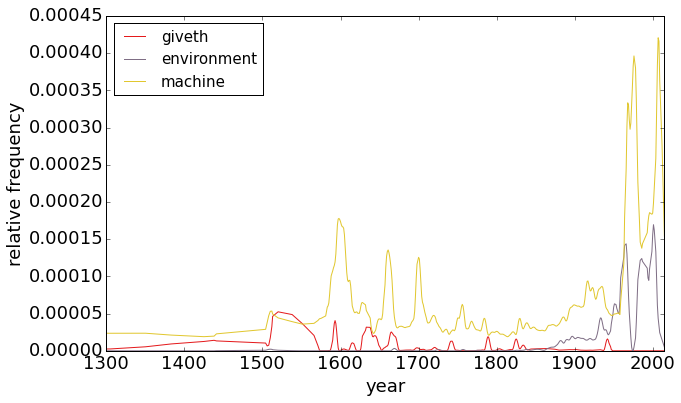

In [89]:
plot_usage_frequency(['giveth', 'environment', 'machine'], year_data, word_lookup, [1300, 2015])

## Language classification

In [121]:
def extract_ngrams(tokens, ngram_range=[1,1]):
    """
    Turn tokens into a sequence of n-grams 

    **Inputs**:

    *tokens*: a list of tokens

    **Optional Keywords**:

    *ngram_range*: a tuple with min, max ngram ngram_range

    **Output**

    Generator yielding a list of ngrams in the desired range
    generated from the input list of tokens

    """

    # handle token n-grams
    min_n, max_n = ngram_range
    n_tokens = len(tokens)
    for n in xrange(min_n, min(max_n + 1, n_tokens + 1)):
        for i in xrange(n_tokens - n + 1):
            if n == 1: 
                yield tokens[i]
            else : 
                yield "".join(tokens[i: i+n])

In [127]:
list(extract_ngrams(list(text)[0:10], [1,2]))

['p',
 'a',
 'g',
 'e',
 'n',
 'o',
 ' ',
 'p',
 'o',
 's',
 'pa',
 'ag',
 'ge',
 'en',
 'no',
 'o ',
 ' p',
 'po',
 'os']